In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from scipy.sparse import diags
from numba import njit

from time import time 
from tqdm.notebook import trange, tqdm

# The well-mixed condition

In this exercise, we will look a bit at the well-mixed condition, suggested by Thomson (1987) as one of several criteria that a stochastic particle model should satisfy to be consistent with a direct solution of the corresponding PDE. It applies to diffusion problems, and other transport problems that reach a steady state after some time (so the coefficient functions $a$ and $b$ should be constant in time (but not necessarily in space), and we need no-flux boundary conditions.)

To take the diffusion equation as an example:

\begin{align}
    \frac{\partial p}{\partial t} = \frac{\partial }{\partial x} \left( K(x) \frac{\partial p}{\partial x}\right).
\end{align}

The well-mixed condition says that if the density is uniform ($p=\mathrm{const}$), then the density should remain uniform, since $\frac{\partial p}{\partial x}=0 \Rightarrow \frac{\partial p}{\partial t}=0$.

### Task a

As we saw in lecture 5, for the general SDE 

$$ \mathrm{d} X = a(X, t) \, \mathrm{d}t + b(X, t) \, \mathrm{d}W, $$

the Fokker-Planck equation is


$$ \frac{\partial p}{\partial t} = -\frac{\partial}{\partial x} \big( a(x, t) \, p(x, t) \big) + \frac{1}{2} \frac{\partial^2}{\partial x^2} \big( b^2(x, t) \, p(x, t) \big). $$

We can use this to find what the coefficients $a(X, t)$ and $b(X, t)$ have to be in order for the Fokker-Planck equation to be identical to the diffusion equation shown above. In Lecture 5, we did this for the advection-diffusion equation, and if we just set $v=0$, we have the diffusion equation. Below, we show another approach, that starts from just the diffusion equation, instead of the advection-diffusion equation. There are probably other (more rigorous) approaches as well.

Rewrite the diffusion equation by adding and subtracting $\frac{\partial}{\partial x}\left(\frac{\partial K}{\partial x} p \right)$ on both sides:

\begin{align}
    \frac{\partial p}{\partial t} &= \frac{\partial }{\partial x} \left( K \frac{\partial p}{\partial x}\right) \\
    &= \frac{\partial }{\partial x} \left( \frac{\partial K}{\partial x}  p +  \frac{\partial p}{\partial x}\right) - \frac{\partial }{\partial x} \left( \frac{\partial K}{\partial x}  p \right) \\
    &= \frac{\partial^2 }{\partial x^2} ( K p ) - \frac{\partial }{\partial x} \left( \frac{\partial K}{\partial x}  p \right).
\end{align}

Compare this to the Fokker-Planck equation:

$$ \frac{\partial p}{\partial t} =  \frac{\partial^2}{\partial x^2} \left(\frac{1}{2} b^2  p \right) -\frac{\partial}{\partial x} \big( a p \big), $$

and we see that the two equations are the same if we set $a = \frac{\partial K}{\partial x}$ and $b = \sqrt{2K}$. Hence we find the SDE

$$ \mathrm{d} X_t = \left. \frac{\partial K}{\partial x} \right|_{X_t} \, \mathrm{d}t + \sqrt{2K(X_t)} \, \mathrm{d}W_t. $$

### Task b

Implement a solver, with reflecting boundaries at 0 and 1. Run until steady state, identified by showing mean particle position as a function of time.

In [2]:
# The Euler-Maruyama method
def EM(X, t, dt, a, b, dW=None):
    # Euler-Maruyama method, with drift a(X, t) and diffusion b(X, t)
    # Unless provided, generate random dW, Gaussian with mean=0 and variance=dta
    # and the correct number of elements
    if dW is None:
        dW = np.random.normal(loc=0, scale=np.sqrt(dt), size=X.shape)
    # Calculate and return next value
    return X + a(X, t)*dt + b(X, t)*dW

# A solver wrapper that can take a boundary handling function
# as an extra argument
def solve_SDE(X0, tmax, dt, a, b, solver, boundary=None, progressbar=True):
    # A simple solve function (assumes dt evenly divides tmax)
    # Calculate number of timsteps (including 0 and tmax)
    Nt = int(tmax/dt) + 1
    # If X0 is not an array, turn it into a 1-element array
    if not isinstance(X0, np.ndarray):
        X0 = np.array([X0])
    # Arrays to track solution
    X = np.zeros((Nt, *X0.shape))
    X[0,:] = X0
    t = 0
    if progressbar:
        iterator = trange
    else:
        iterator = range
    for n in iterator(1, Nt):
        # Call solver
        X[n,:] = solver(X[n-1,:], t, dt, a, b)
        # If provided, apply the function that implements behaviour at the boundary
        if boundary is not None:
            X[n,:] = boundary(X[n,:])
            
        t += dt
    return X

def reflect(X, xmin=0, xmax = 1):
    # Reflect as many times as needed, until all particles are inside
    while np.any((X < xmin) | (X > xmax)): # Note that | is shorthand for np.logical_or in this case
        X = np.where(X < xmin, X+2*(xmin - X), X)
        X = np.where(X > xmax, X+2*(xmax - X), X)
    return X

  0%|          | 0/30 [00:00<?, ?it/s]

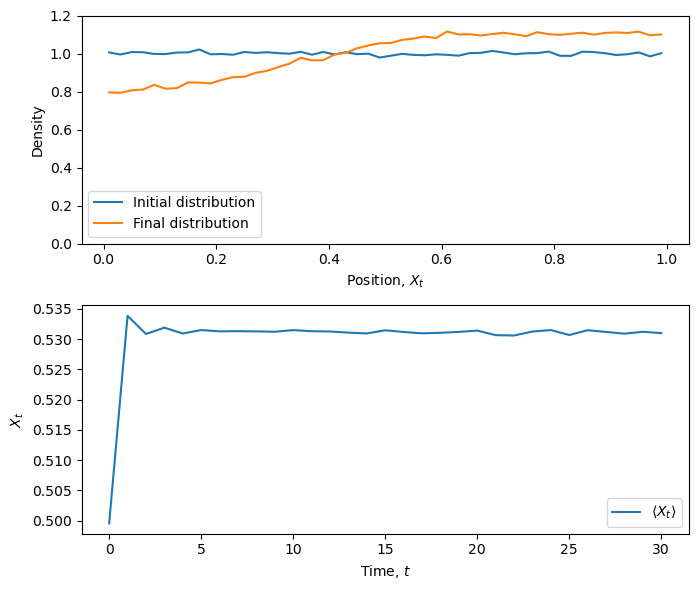

In [3]:
# Define K(x) and its derivative

K0 = 1e-2
K1 = 5e-1

def K(x):
    # Choosing a linear function of x
    return K1*x + K0

def dKdx(x):
    # Analytical derivative in this simple case
    return K1

# Implementing a and b as functions
def a(X, t):
    return dKdx(X)

def b(X, t):
    return np.sqrt(2*K(X))

# Several initial values leads to several solutions
Np = 1000000
X0 = np.random.uniform(low=0, high=1, size=Np)
# Integration time
tmax = 30
# timestep
dt = 1

X = solve_SDE(X0, tmax, dt, a, b, EM, boundary=reflect)

times = dt*np.arange(X.shape[0])
bins, dx =np.linspace(0, 1, 51, retstep=True) # bins
mids=bins[:-1] + (bins[1]-bins[0])/2 # midpoints of the bins

# Plot the solution
fig, ax = plt.subplots(nrows=2, figsize = (7, 6))

h, _ = np.histogram(X[0,:], bins=bins, density=True)
ax[0].plot(mids, h, label='Initial distribution')
h, _ = np.histogram(X[-1,:], bins=bins, density=True)
ax[0].plot(mids, h, label='Final distribution')
ax[0].legend()
ax[0].set_xlabel('Position, $X_t$')
ax[0].set_ylabel('Density')
ax[0].set_ylim(0, 1.2)
    
ax[1].plot(times, np.mean(X, axis=1), label='$\langle X_t \\rangle$')
ax[1].set_xlabel('Time, $t$')
ax[1].set_ylabel('$X_t$')
ax[1].legend()

plt.tight_layout()

### Task c

Repeat the above, but run for different timesteps and plot error in mean particle position as function of timestep.

  0%|          | 0/6 [00:00<?, ?it/s]

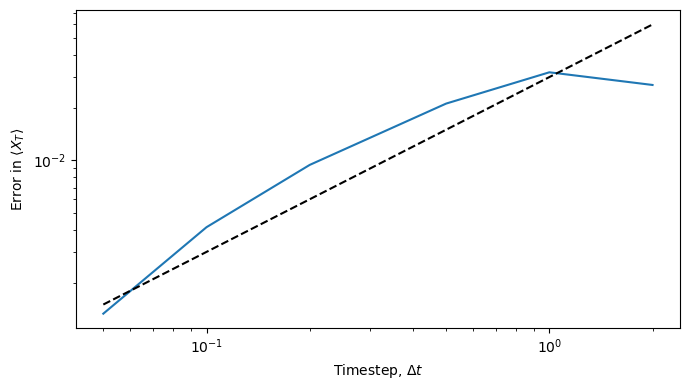

In [4]:
# Define K(x) and its derivative

K0 = 1e-2
K1 = 5e-1

def K(x):
    # Choosing a linear function of x
    return K1*x + K0

def dKdx(x):
    # Analytical derivative in this simple case
    return K1

# Implementing a and b as functions
def a(X, t):
    return dKdx(X)

def b(X, t):
    return np.sqrt(2*K(X))

# Several initial values leads to several solutions
Np = 1000000
X0 = np.random.uniform(low=0, high=1, size=Np)
# Integration time
tmax = 16


# loop over timesteps
timesteps = np.array([0.05, 0.1, 0.2, 0.5, 1, 2])
errors = np.zeros_like(timesteps)
for i, dt in enumerate(tqdm(timesteps)):
    X = solve_SDE(X0, tmax, dt, a, b, EM, boundary=reflect, progressbar=False)
    errors[i] = np.abs(np.mean(X[-1,:]) - 0.5) # 0.5 is the correct mean for uniform(0, 1)

# Plot the solution
fig = plt.figure(figsize=(7,4))

plt.plot(timesteps, errors)
plt.plot(timesteps, 3e-2*timesteps, '--', c='k', label='$\sim \Delta t')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Timestep, $\Delta t$')
plt.ylabel('Error in $\langle X_T \\rangle$')
plt.tight_layout()

### Task d

Here we tweak the diffusivity function to make the derivative, $\partial K / \partial x$,  go to zero at the boundary. The modification that was suggested in the exercise is taken from Exercise 4.10 in Øksendal (the topic of that exercise is unrelated, and the modification is used to make an approximation of the function $f(x) = |x|$ which has a continuous derivative).


The modification suggested was the following:

\begin{align}
    K(x) = \left\{ \begin{array}{ccc} K_0 + x K_1 & \mathrm{if} &  x \geq h, \\
    K_0 + \frac{K_1}{2} \left(h + \frac{x^2}{h}\right) & \mathrm{if} & x < h. \end{array} \right.
\end{align}

The idea is that if we are close to zero ($0 <= x <= h$) we replace the linear $K(x)$ with a parabola that has zero derivative at $0$, and we do this in such a way that the derivative is continous when we cross the point $h$. The smaller we make $h$, the closer we approximate the original function, $K(x)$. This is illustrated below.

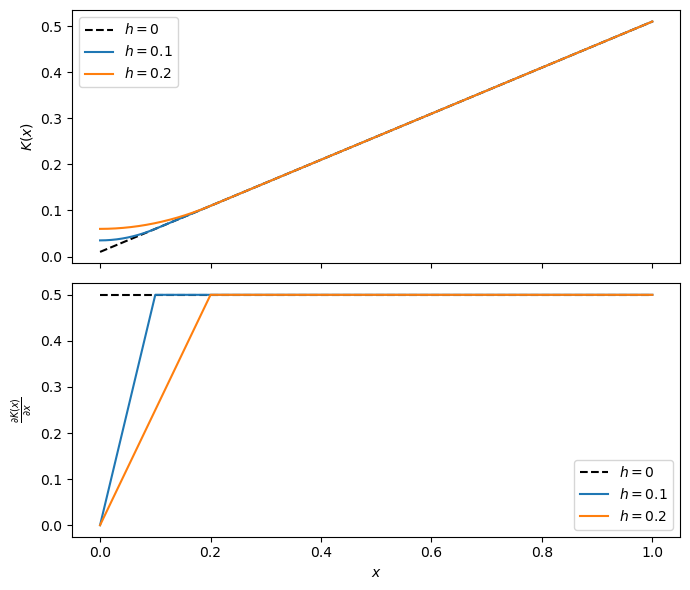

In [5]:
K0 = 0.01
K1 = 0.5

def K(x, h=0.1):
    if h == 0:
        # Implementing the special case h=0 separately,
        # as we otherwise gets warnings about division by zero,
        # since np.where calculates all elements for both cases
        return K0 + K1*x
    else:
        return np.where(x < h, K0 + K1*(h + x**2 / h)/2, K0 + K1*x)

def dKdx(x, h=0.1):
    if h == 0:
        # Implementing the special case h=0 separately,
        # as we otherwise gets warnings about division by zero,
        # since np.where calculates all elements for both cases
        return K1 * np.ones_like(x)
    else:
        return np.where(x < h, K1*x/h, K1)

x = np.linspace(0, 1, 1001)

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(7,6))
ax[0].plot(x, K(x, h=0), '--', c='k', label='$h=0$')
ax[0].plot(x, K(x, h=0.1), label='$h=0.1$')
ax[0].plot(x, K(x, h=0.2), label='$h=0.2$')

ax[1].plot(x, dKdx(x, h=0), '--', c='k', label='$h=0$')
ax[1].plot(x, dKdx(x, h=0.1), label='$h=0.1$')
ax[1].plot(x, dKdx(x, h=0.2), label='$h=0.2$')

ax[0].legend()
ax[1].legend()
ax[1].set_xlabel('$x$')
ax[0].set_ylabel('$K(x)$')
ax[1].set_ylabel('$\\frac{\partial K(x)}{\partial x}$')
plt.tight_layout()

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

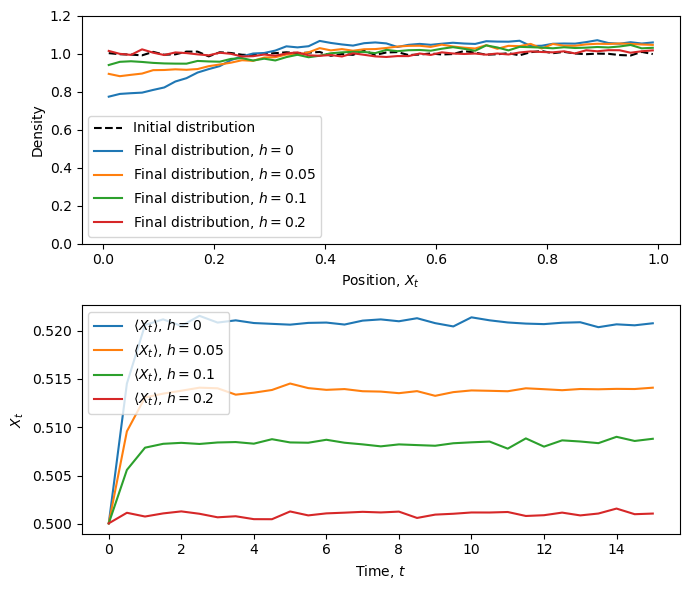

In [6]:
# Define K(x) and its derivative
K0 = 0.01
K1 = 0.5

def K(x, h=0.1):
    if h == 0:
        # Implementing the special case h=0 separately,
        # as we otherwise gets warnings about division by zero,
        # since np.where calculates all elements for both cases
        return K0 + K1*x
    else:
        return np.where(x < h, K0 + K1*(h + x**2 / h)/2, K0 + K1*x)

def dKdx(x, h=0.1):
    if h == 0:
        # Implementing the special case h=0 separately,
        # as we otherwise gets warnings about division by zero,
        # since np.where calculates all elements for both cases
        return K1 * np.ones_like(x)
    else:
        return np.where(x < h, K1*x/h, K1)

    
# Initial positions
Np = 1000000
X0 = np.random.uniform(low=0, high=1, size=Np)
# Integration time
tmax = 15
# timestep
dt = 0.5

# Histogram bins
bins, dx =np.linspace(0, 1, 51, retstep=True) # bins
mids=bins[:-1] + (bins[1]-bins[0])/2 # midpoints of the bins


# Figure to plot the solution
fig, ax = plt.subplots(nrows=2, figsize = (7, 6))
# Plot initial distribution
hist, _ = np.histogram(X0, bins=bins, density=True)
ax[0].plot(mids, hist, '--', c='k', label=f'Initial distribution')

for h in [0, 0.05, 0.1, 0.2]:
    # Implementing a and b as functions with the desired h
    a = lambda x, t : dKdx(x, h=h)
    b = lambda x, t : np.sqrt(2*K(x, h=h))
    
    # Run simulation
    X = solve_SDE(X0, tmax, dt, a, b, EM, boundary=reflect)
    
    # Plot results
    hist, _ = np.histogram(X[-1,:], bins=bins, density=True)
    ax[0].plot(mids, hist, label=f'Final distribution, $h={h}$')
    times = dt*np.arange(X.shape[0])
    ax[1].plot(times, np.mean(X, axis=1), label=f'$\langle X_t \\rangle$, $h={h}$')


ax[0].legend()
ax[0].set_xlabel('Position, $X_t$')
ax[0].set_ylabel('Density')
ax[0].set_ylim(0, 1.2)
    
ax[1].set_xlabel('Time, $t$')
ax[1].set_ylabel('$X_t$')
ax[1].legend()

plt.tight_layout()

## Another variant on Task d

Another option to modify the linear diffusivity is to use some sigmoidal function that is linear in $x$ close to zero, and transitions smoothly to being 0 across some interval $h$. Then we simply scale this function appropriately, and subtract it from our original function, such that the difference of the two functions is a constant close to 0, and approximately equal to the original function for $x \gg h$.

This is illustrated below, using $1 - \tanh(x/h)$ as the sigmoidal function, that is we replace our linear $K(x)$ by

$$ K(x) = K_0 + K_1 x + K_1 h \big( 1 - \tanh(x/h) \big). $$

When $x \ll h$, we have that $1 - \tanh(x/h) \approx 1$, so the modified function becomes a constant equal to $K_0 + K_1 h$. When $x \gg h$, we have $ 1 - \tanh(x/h) \approx 0$, so we recover the original function. Compared to the previous example, this has the advantage that the higher derivatives are also continuous.

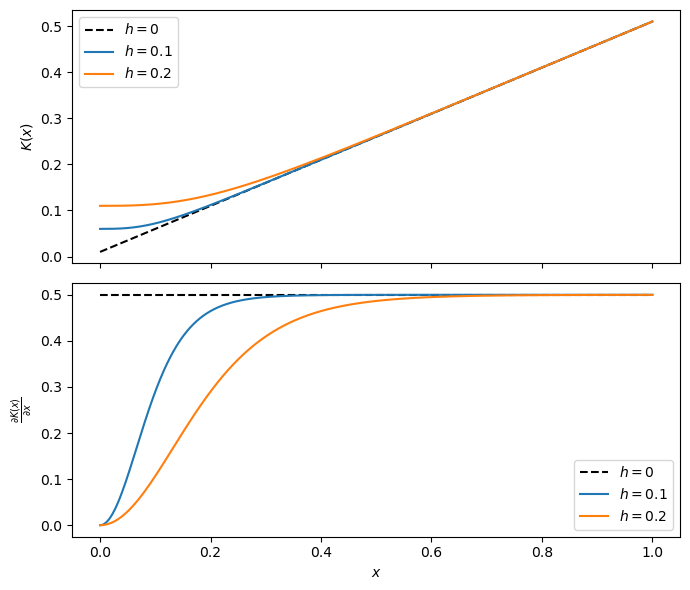

In [7]:
K0 = 0.01
K1 = 0.5

def K(x, h=0.1):
    if h == 0.0:
        # Implementing the special case h=0 separately,
        # as we otherwise gets warnings about division by zero,
        # since np.where calculates all elements for both cases
        return K0 + K1*x
    else:
        return K0 + K1*x + K1*h*(1-np.tanh(x/h))

def dKdx(x, h=0.1):
    if h == 0:
        # Implementing the special case h=0 separately,
        # as we otherwise gets warnings about division by zero,
        # since np.where calculates all elements for both cases
        return K1 * np.ones_like(x)
    else:
        return K1 - K1*(1-np.tanh(x/h)**2)

x = np.linspace(0, 1, 1001)

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(7,6))
ax[0].plot(x, K(x, h=0), '--', c='k', label='$h=0$')
ax[0].plot(x, K(x, h=0.1), label='$h=0.1$')
ax[0].plot(x, K(x, h=0.2), label='$h=0.2$')

ax[1].plot(x, dKdx(x, h=0), '--', c='k', label='$h=0$')
ax[1].plot(x, dKdx(x, h=0.1), label='$h=0.1$')
ax[1].plot(x, dKdx(x, h=0.2), label='$h=0.2$')

ax[0].legend()
ax[1].legend()
ax[1].set_xlabel('$x$')
ax[0].set_ylabel('$K(x)$')
ax[1].set_ylabel('$\\frac{\partial K(x)}{\partial x}$')
plt.tight_layout()

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

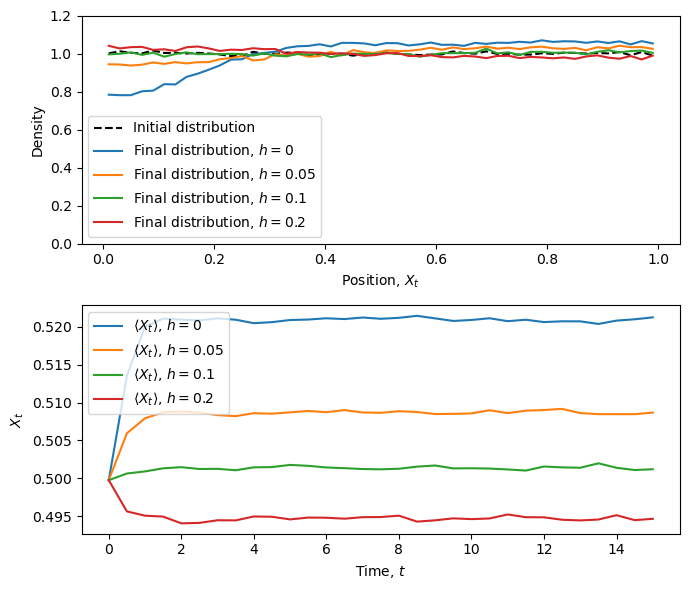

In [8]:
# Define K(x) and its derivative
K0 = 0.01
K1 = 0.5

def K(x, h=0.1):
    if h == 0:
        # Implementing the special case h=0 separately,
        # as we otherwise gets warnings about division by zero,
        # since np.where calculates all elements for both cases
        return K0 + K1*x
    else:
        return K0 + K1*x + K1*h*(1-np.tanh(x/h))

def dKdx(x, h=0.1):
    if h == 0:
        # Implementing the special case h=0 separately,
        # as we otherwise gets warnings about division by zero,
        # since np.where calculates all elements for both cases
        return K1 * np.ones_like(x)
    else:
        return K1 - K1*(1-np.tanh(x/h)**2)

    
# Initial positions
Np = 1000000
X0 = np.random.uniform(low=0, high=1, size=Np)
# Integration time
tmax = 15
# timestep
dt = 0.5

# Histogram bins
bins, dx =np.linspace(0, 1, 51, retstep=True) # bins
mids=bins[:-1] + (bins[1]-bins[0])/2 # midpoints of the bins


# Figure to plot the solution
fig, ax = plt.subplots(nrows=2, figsize = (7, 6))
# Plot initial distribution
hist, _ = np.histogram(X0, bins=bins, density=True)
ax[0].plot(mids, hist, '--', c='k', label=f'Initial distribution')

for h in [0, 0.05, 0.1, 0.2]:
    # Implementing a and b as functions with the desired h
    a = lambda x, t : dKdx(x, h=h)
    b = lambda x, t : np.sqrt(2*K(x, h=h))
    
    # Run simulation
    X = solve_SDE(X0, tmax, dt, a, b, EM, boundary=reflect)
    
    # Plot results
    hist, _ = np.histogram(X[-1,:], bins=bins, density=True)
    ax[0].plot(mids, hist, label=f'Final distribution, $h={h}$')
    times = dt*np.arange(X.shape[0])
    ax[1].plot(times, np.mean(X, axis=1), label=f'$\langle X_t \\rangle$, $h={h}$')


ax[0].legend()
ax[0].set_xlabel('Position, $X_t$')
ax[0].set_ylabel('Density')
ax[0].set_ylim(0, 1.2)
    
ax[1].set_xlabel('Time, $t$')
ax[1].set_ylabel('$X_t$')
ax[1].legend()

plt.tight_layout()

## References

Kloeden & Platen (1992), _Numerical Solution of Stochastic Differential Equations_. https://link.springer.com/book/10.1007/978-3-662-12616-5